# Redes Neuronales 2020
## Trabajo Práctico 1
### Modelo de Lotka-Volterra

El **Modelo de predadores y presas de Lotka-Volterra**, descrito como el sistema de dos ecuaciones diferenciales ordinarias (ODEs):

$$ \dot{C}(t) = \alpha C(t) - \beta C(t) Z(t) $$
$$ \dot{Z}(t) = - \gamma Z(t) + \delta C(t) Z(t) $$

Donde:

- $ C(t) $ modela el número de presas de un ecosistema
- $ Z(t) $ modela el número de depredadores en el mismo ecosistema

Se considerarán los siguientes valores para los parámetros:

$$ \alpha = 0.1 \qquad \beta = 0.02 \qquad \gamma = 0.3 \qquad \delta = 0.01 $$

### Imports

In [2]:
import numpy as np
import scipy as sp
import seaborn as sns
import matplotlib.pyplot as plt
from autoclass import autoargs
from scipy import integrate
sns.set_style("darkgrid")
np.random.seed(23)

### Modelo Lotka-Volterra

Definimos una clase para trabajar cómodamente con el modelo, tomando los parámetros dados.

In [4]:
class LotkaVolterraModel:
    """
    El sistema de ecuaciones diferenciales ordinarias,
    más conocido como el Modelo de Lotka-Volterra.
    Notación: `dF_dx -> Derivada de F sobre x`

    Parámetros:
        float alpha: Tasa de natalidad (presas)
        float delta: Tasa de mortalidad (presas)
        float gamma: Tasa de natalidad (depredadores)
        float delta: Tasa de mortalidad (depredadores)
    """

    @autoargs
    def __init__(self, alpha, beta, gamma, delta):
        self.dP_dt = lambda p, d: (alpha * p) - (beta * p * d)
        self.dD_dt = lambda p, d: (delta * p * d) - (gamma * d)

    """ Evaluación """
    def __call__(self, count):
        return np.array((
            self.dP_dt(count[0], count[1]),
            self.dD_dt(count[0], count[1])
        ), np.float32)

Comenzaremos por inicializar nuestro modelo con los parámetros antes mencionados y probamos el modelo con un caso base, donde ambas poblaciones son nulas, es decir que no tenemos ni presas ni depredadores, para verificar que ninguna crece:

In [6]:
model = LotkaVolterraModel(
    alpha=.1,
    beta=.02,
    gamma=.3,
    delta=.01
)

model((0, 0))

array([0., 0.], dtype=float32)

### Algoritmo de Runge Kutta de 4to Orden

Vamos a implementar el algoritmo RK4 para aproximar las integrales de nuestro modelo. Estas aproximaciones nos van a servir para conocer y visualizar el comportamiento del modelo y extraer conclusiones: 

In [7]:
def runge_kutta_4(model, p0, trange=(0, 200), h=0.05):
    """
    Algoritmo Runge-Kutta de 4to Orden.
    Parámetros:
        callable model: Modelo a evaluar
        (float, float) p0: Punto (x, y) inicial
        (float, float) trange: Rango temporal a utilizar
        float h: Paso de integraci√≥n
    Devuelve:
        np.array(np.float32) X: Aproximaciones de X
        np.array(np.float32) Y: Aproximaciones de Y
        np.array(np.float32) T: Puntos temporales utilizados
    """
    # inicializamos
    T = np.arange(*trange, h, np.float32)
    x, y = p0
    r = np.array([x, y], np.float32)
    X, Y = np.array([], np.float32), np.array([], np.float32)

    for t in T:
        # actualizamos los puntos
        X = np.append(X, r[0])
        Y = np.append(Y, r[1])

        # paso runge-kutta
        k1 = h * model(r)
        k2 = h * model(r + 0.5 * k1)
        k3 = h * model(r + 0.5 * k2)
        k4 = h * model(r + k3)
        r += (k1 + 2 * k2 + 2 * k3 + k4)/6

    return X, Y, T

### Diagrama de Fase

Ahora que tenemos un método para aproximar los valores de nuestro modelo, vamos a hacer un diagrama de fases para conocer la relación entre la cantidad de presas y depredadores con distintos puntos iniciales. Comenzaremos por definir un método que nos permita realizar este gráfico.

In [10]:
def plot_df(model, fases, n_vect):
    """
    Gráfico del diagrama de fases en conjunto con el diagrama de direcci√≥n.
    Parámetros:
        callable model: Modelo a evaluar
        np.array(np.float32) fases: puntos iniciales para cada fase
        int n_vect: vectores de direcci√≥n a mostrar
    """

    # inicializamos el gr√°fico
    f, ax = plt.subplots(1, figsize=(12, 8))
    ax.set_title(f'Diagrama de fases')
    ax.set_xlabel('Poblaci√≥n de presas')
    ax.set_ylabel('Poblaci√≥n de depredadores')

    # aproximamos el comportamiento dados estos puntos
    # utilizando Runge Kutta y los graficamos
    for p0 in fases:
        X, Y, _ = runge_kutta_4(model=model, p0=p0)
        ax.plot(X, Y, label=f'p0 = ({p0[0]:.2f}, {p0[1]:.2f})')

    # construimos una grilla sobre los l√≠mites del gr√°fico
    # con la cantidad de vectores definida
    X, Y = np.meshgrid(
        np.linspace(0, plt.xlim(xmin=0)[1], n_vect),
        np.linspace(0, plt.ylim(ymin=0)[1], n_vect)
    )

    # computamos la tasa de crecimiento sobre la grilla
    DX, DY = model((X, Y))

    # normalizamos la tasa y evitamos divisi√≥n por cero
    M = (np.hypot(DX, DY))
    M[M == 0] = 1.
    DX /= M
    DY /= M

    # graficamos los vectores
    Q = plt.quiver(X, Y, DX, DY, M, pivot='mid')

    # mostramos el gr√°fico
    ax.grid()
    ax.legend()
    plt.show()

Ahora vamos a inicializar 5 puntos iniciales al azar utilizando una distribución uniforme entre 5 y 40 y graficar el diagrama de fases, en conjunto con el campo vectorial para ver cómo se relacionan C y Z:

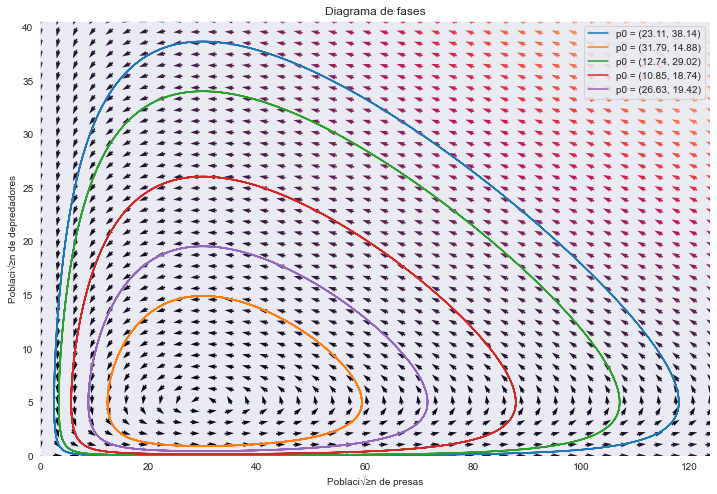

In [11]:
fases = np.random.uniform(5, 40, size=(5, 2))

plot_df(
    model,
    fases=fases,
    n_vect=40
)

Como podemos ver en el gráfico, sin importar el punto inicial, vemos que siempre siguen un ciclo y en ningún momento se estabilizan, el campo vectorial marca este comporamiento. Para terminar nuestro análisis, vamos a verificar esta afirmación viendo la evolución del modelo a través del tiempo con un punto inicial determinado.

### Evolución a través del tiempo

Vamos a definir un método que nos permita aproximar con Runge-Kutta nuestro modelo en un rango temporal determinado y luego graficar el resultado.

In [13]:
def plot_evolution(model, p0, trange, h):
    """
    Gráfico de la aproximación de la evolución de un modelo
    a través del tiempo, utilizando Runge Kutta de 4to orden.

    Parámetros:
        callable model: Modelo a evaluar
        (float, float) p0: Punto (x, y) inicial
        (float, float) trange: Rango temporal a utilizar
        float h: Paso de integraci√≥n
    """

    # aproximamos la evoluci√≥n con rk4
    P, D, T = runge_kutta_4(
        model,
        p0=p0,
        trange=trange,
        h=h
    )

    # inicializamos el gr√°fico
    f, ax = plt.subplots(1, figsize=(10, 8))
    ax.set_title('''
Evolución a trav√©s del tiempo de Lotka-Volterra
   con p0=(40, 9), t en (0, 200) y h = 0.05
    ''')
    ax.set_xlabel('Tiempo')
    ax.set_ylabel('Población')

    # graficamos los resultados a trav√©s del tiempo
    ax.plot(T, P, label='Presas')
    ax.plot(T, D, label='Depredadores')

    ax.legend()
    plt.show()

Ahora vamos a utilizar esta función para graficar los resultados en el rango temporal (0, 200), con un punto inicial de (40, 9) y con un h de 0.05:

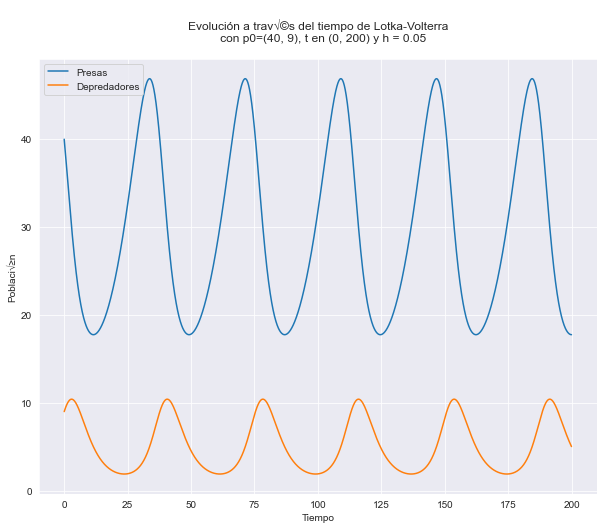

In [14]:
plot_evolution(
    model,
    p0=(40, 9),
    trange=(0, 200),
    h=0.05
)

### Conclusión

Como podemos observar en los gráficos realizados, el modelo de Lotka-Volterra tiene la particularidad de no tener un punto en estable. Podríamos asumir que el modelo tiene un comportamiento cíclico, en el que sin importar el punto inicial, las poblaciones no van a caer en una constante. Esta afirmación tiene sentido ya que el tamaño de cada población depende directamente del crecimiento/decrecimiento de la otra.

En el primer gráfico vemos que el factor del punto inicial no genera grandes diferencias a la hora de ver la relación entre ambas poblaciones y todas siguen siempre el mismo campo vectorial. En el segundo gráfico vemos que, dado el punto inicial, el modelo fluctúa constantemente y al parecer no converge hacia ningún valor.